# Distrubution network solved using Simulated Anneling

This is the third assingment of Business Analytics module. The assignment solves the same problem like the second one, finding optimal locations for distrubution centers (DCs) in Europe. However, this time, a heuristic is used and a number of DCs is fixed to seven.

## Procedure
A heuristics chosen for this assignment is <a href="https://en.wikipedia.org/wiki/Simulated_annealing">Simulated Annealing</a> with following setting:

* The first seven cities from the data are taken as the initial set of DCs (i.e., temporary solution = ['Amsterdam', 'Antwerp', 'Athens', 'Barcelona', 'Berlin', 'Bern','Brussels'])
* Every iteration, one of the cities of the temporary solution is randomly switched with a different one that is not in the set. 
* Parameters were set as T = 1000 and it is decreased in every step with a factor of 0.999. The algorithm stops when T < 5. Value of T was selected to be similar to the mean (i.e., 1105 km) of distance between cities. Stopping criteria was selected given the exponential function of Simulated Anneling. Values lower than 5 yields extermnly small numbers and it makes no sense to inspect solutions further (e.g., decrease in cost delta by 50 while having T = 5 yields math.exp(-50 / 5) = 4.53e-05.)
* Temporary solutions are evaluted such that a temporary distance matrix is created having DCs in columns and all cities in row. Than, minimum of each row of this matrix is found. The sum of all rows is equal to the total cost. This step is extermly fast.
* Each time, it is evaluated whether the cost for a temporary solution has been computed earlier. This is done in a way that each city is represent with a unique id (i.e., 1--37). A temporary set of DCs is then represented by a 'blueprint' that can be expressed as $$\sum_{id}^{Temp. DCs} 2^{id}$$ Finally, each blueprint is stored in a sorted array and every time before a computation of a new temporary solution, binary search is used to search in this array.

## Results
The results obtained:
* Avarage cost found in 30 runs is 11307.27 ([1]) eur and it was found in avg in 0.86s and in 528 iterations (T = 1000, step = 0.99).
* Avarage cost found in 30 runs is 10642.40 eur and it was found in avg in 8.21s and in 5296 iterations (T = 1000, step = 0.999).

Plotting time and number of iterations vs costs for one particular solution (T = 1000, step = 0.999) resulted in following figure:
<img src="time-iter-vs-cost.png" />

According to the solution displayed on the figure, following cities would be opended as DCs: Prague, Antwerp, Lisbon, Turin, Naples, Stuttgart, and Athens. The costs will be 10331 eur. These cities on a Google Maps together with the optimal solutions:
<img src="heur-map.png" width="450" />

[1] - note that all numbers related to costs are in units of 100.

In [1]:
# Load libraries and setup constansts
from gurobipy import *
import pandas as pd
import numpy as np
from bokeh.io import show, output_notebook
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool
)
from random import randint
import math, random, bisect, time
import matplotlib.pyplot as plt

#loading the distance matrix
dists = pd.read_csv('cities_dist.csv')
dists = dists.drop('Distance (km)', 1) #dropping the first column with 
n_clusters = 7 # count of DCs
cities = np.array(list(dists))
n_cities = dists.shape[0]

#loading gps coordinates of the cities
gps_coords = pd.read_csv('gps.txt')
gps_coords_opt = gps_coords[gps_coords['Address'].isin(['Athens', 'Brussels', 'Hamburg', 'Madrid', 'Munich', 'Naples', 'Turin'])]

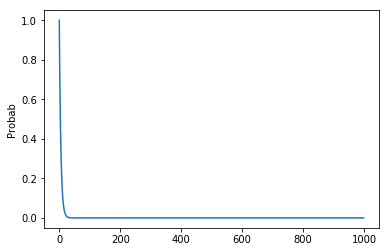

Given probability of 0.10, difference can be at most 12. This is considered small enough for algorithm to stop


In [2]:
#Inspecting how the exponential function from simulatted anneling work and finding optimal stoppin parameter for T. 
T_stop= 5
T = 1000
cost_delta = np.array(range(0, T))
anneling_data = np.exp(-cost_delta / T_stop)
plt.plot(anneling_data)
plt.ylabel('Probab')
plt.show()
probab_cutoff = 0.1
print("Given probability of %.2f, difference can be at most %d. This is considered small enough for algorithm to stop"
      % (probab_cutoff, np.sum(anneling_data > 0.1)))

In [3]:
#simulated anneling
def get_cost(DCs, dists):    
    DCs_dist = dists.ix[DCs]
    sum = np.sum(DCs_dist.apply(lambda row: np.min(row),axis=0))
    return sum

def randomly_generate(DCs, n_clusters, n_cities, cities):
    """Randomly exchange one of the DCs for another city."""
    DC_replace = randint(0, n_clusters - 1)
    city_non_selected = list(set(range(0,n_cities)) - set(DCs))
    city_select = random.choice(city_non_selected)
    DCs[DC_replace] = city_select
    return DCs 

def compute_DC_blueprint(DCs):
    """Returns blueprint of a set of DCs"""
    return np.sum([2**DC for DC in DCs])


def binary_search(a, x):
    'Locate the leftmost value exactly equal to x. Return true if value is found.'
    i = bisect.bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return True
    return False

def simu_anneling_dc(T = 1000, T_stop = 5, step = 0.999):
    """Runs simulated anneling."""
    DCs_cur = list(range(0, n_clusters)) #take the first 7 cities as the starting situation
    cost_cur = get_cost(DCs_cur, dists)
    DCs_best, cost_best = DCs_cur[:], cost_cur 
    i = 0
    DCs_computed = [] #blueprint of DCs for which the distances were computed.
    costs_best_plot, time_best_plot, num_iter_plot = [], [], [] #array to track the best resutls in time
    time_start = time.time()
    while True:
        DCs_tmp = randomly_generate(DCs_cur, n_clusters, n_cities, cities)
        DCs_tmp_blueprint = compute_DC_blueprint(DCs_tmp)
        if not binary_search(DCs_computed, DCs_tmp_blueprint): #only if we have not visited the 
            bisect.insort_left(DCs_computed, DCs_tmp_blueprint) 
            cost_tmp = get_cost(DCs_cur, dists)
            cost_delta =  cost_cur - cost_tmp # i want lower costs    
            if cost_delta > 0 or math.exp(cost_delta / T) > random.random():
                DCs_cur, cost_cur = DCs_tmp[:], cost_tmp        
                if cost_best > cost_cur:
                    cost_best = cost_cur
                    DCs_best = DCs_tmp[:]        
                elapsed = time.time() - time_start
                costs_best_plot.append(cost_cur)
                time_best_plot.append(elapsed)
                num_iter_plot.append(i)
                #print("%dx, %.1fs,   %d: %s" % (i, elapsed, cost_tmp, cities[DCs_tmp] ))  
        T = T * step
        i+=1
        if T < T_stop:
            break
    return time_best_plot, costs_best_plot, DCs_best, cost_best, num_iter_plot

In [4]:
#evaluating of simulated anneling 
def evalute_simulated_analing_loop(iterations, T, T_stop, step):
    cost_best_loop, time_best_loop, num_iters = [], [], []
    
    for i in range(iterations):
        time_best_plot, _, _, cost_best, num_iter_plot = simu_anneling_dc(T = T, T_stop = T_stop, step = step)
        cost_best_loop.append(cost_best)
        time_best_loop.append(time_best_plot[-1])
        num_iters.append(num_iter_plot[-1])
        print("%d / %d" % (i, iterations))

    print("Avarage cost found in %d runs is %.2f and it was found in avg in %.2fs and in %d iterations" % 
          (iterations, np.mean(cost_best_loop), np.mean(time_best_loop), np.mean(num_iters)))
    
evalute_simulated_analing_loop(iterations = 1, T = 1000, T_stop = 5, step = 0.99)
#evalute_simulated_analing_loop(iterations = 30, T = 1000, T_stop = 5, step = 0.999)

0 / 1
Avarage cost found in 1 runs is 10775.00 and it was found in avg in 1.26s and in 447 iterations


The cost is 10691 and DCs are ['Brussels' 'Turin' 'Geneva' 'Naples' 'Athens' 'Berlin' 'Madrid'] 


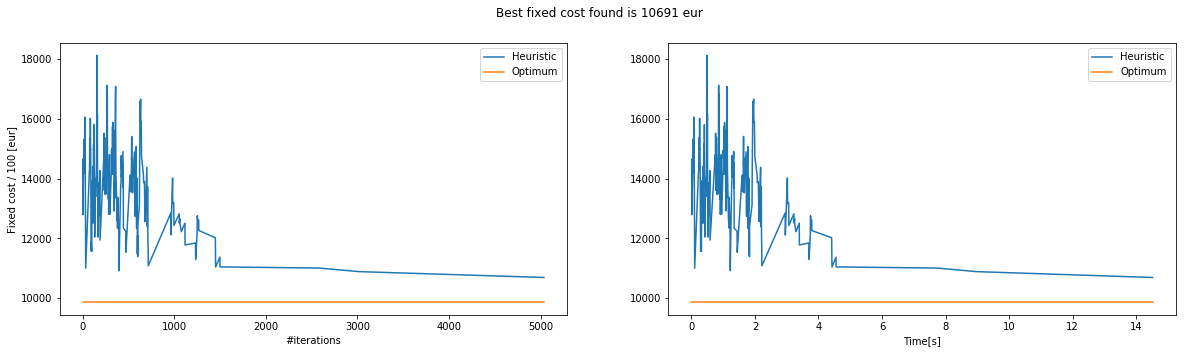

In [5]:
#plotting results of simulated anneling using a single iteration
time_best_plot, costs_best_plot, DCs_best, cost_best, num_iter_plot = simu_anneling_dc(T = 1000, T_stop = 5, step = 0.999)

print("The cost is %d and DCs are %s " % (cost_best, cities[DCs_best]))
seconds_elapsed = math.ceil(time_best_plot[-1])

plt.figure(figsize=(20,5))
plt.subplot(121)
heur_line, = plt.plot(num_iter_plot, costs_best_plot)
opt_line, = plt.plot([0,num_iter_plot[-1] ],[9855,9855])
plt.ylabel('Fixed cost / 100 [eur]')
plt.xlabel('#iterations')
plt.legend([heur_line, opt_line], ['Heuristic', 'Optimum'])

plt.subplot(122)
heur_line, = plt.plot(time_best_plot, costs_best_plot)
opt_line2, = plt.plot([0,time_best_plot[-1] ],[9855,9855])
#plt.ylabel('Fixed cost / 100 [eur]')
plt.xlabel('Time[s]')
plt.legend([heur_line, opt_line2],['Heuristic', 'Optimum'])

plt.suptitle('Best fixed cost found is %d eur' % cost_best)
plt.show()

In [6]:
#visulizing the best obtained DCs in a map
def get_plot_cities(gps_coords, gps_coords_heur, gps_coords_opt):
    """Get a GG maps plot and with plotted cities of optimal and heuristic solution."""
    map_options = GMapOptions(lat=53.55, lng=9.99, map_type="roadmap", zoom=4)
    plot = GMapPlot(x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)
    plot.title.text = "Green = DCs determined by LP | Red = DCs determined by a heuristic" 
    plot.api_key = "GOOGLE_API_HERE"
    all_cities = ColumnDataSource(data= dict(lat=gps_coords['Latitude'], lon=gps_coords['Longitude'],))
    heur_DC = ColumnDataSource(data=dict(lat=gps_coords_heur['Latitude'], lon=gps_coords_heur['Longitude'],))
    opt_DC = ColumnDataSource(data=dict(lat=gps_coords_opt['Latitude'], lon=gps_coords_opt['Longitude'],))

    circle_all = Circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.7, line_color=None)
    plot.add_glyph(all_cities, circle_all)

    circle_opt = Circle(x="lon", y="lat", size=12, fill_color="#10ff00", fill_alpha=1, line_color=None)
    plot.add_glyph(opt_DC, circle_opt)

    circle_heur = Circle(x="lon", y="lat", size=8, fill_color="#ff7200", fill_alpha=1, line_color=None)
    plot.add_glyph(heur_DC, circle_heur)

    plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())
    return plot

gps_coords_heur = gps_coords[gps_coords['Address'].isin(cities[DCs_best])] #getting GPS coords
show(get_plot_cities(gps_coords, gps_coords_heur, gps_coords_opt)) 

In [7]:
#unit testing of the anneling
import unittest
class TestAnnealing(unittest.TestCase):    
    def test_get_cost(self):
        """Testing whether optimal DCs cost is equal to the value obtained from gurobi."""
        DCs_opt = ['Athens', 'Brussels', 'Hamburg', 'Madrid', 'Munich', 'Naples', 'Turin']
        DCs_opt_ind = [i for i in range(len(cities)) if cities[i] in DCs_opt]
        cost_opt = 9855
        self.assertEqual(get_cost(DCs_opt_ind, dists), cost_opt)

a = TestAnnealing()
suite = unittest.TestLoader().loadTestsFromModule(a)
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Distrubution network solved using Hierchical clustering

In [8]:
#Solving the problem using Hierrachical clustering
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
cities_list = list(dists)
dists_num = dists.as_matrix()
time_start = time.time()
model = AgglomerativeClustering(linkage="average", affinity='precomputed', n_clusters=n_clusters)
model.fit(dists_num)

#Obtaining centroid of the clusters for the clustering and computing objective value - ugly solution
obj_trans_cost = 0
heur_DCs = []
for i in range(n_clusters):   
    current_centroid = ('nill', 1000000)
    cities_cluster = cities[model.labels_ == i]
    for city in cities_cluster:            
        city_total_dist = 0
        for city2 in cities_cluster:
            if city != city2:
                city_ind = cities_list.index(city)
                city2_ind = cities_list.index(city2)
                city_total_dist += dists_num[city_ind,city2_ind]
        if city_total_dist < current_centroid[1]:
            current_centroid = (city, city_total_dist)
    obj_trans_cost+= current_centroid[1]
    heur_DCs.append(current_centroid[0])
    print("DC %s serves: %s" % (current_centroid[0], cities_cluster))    
elapsed = time.time() - time_start

print("Obj value %d and it was retrived in %.4fs." % (obj_trans_cost, elapsed))

DC Bern serves: ['Bern' 'Geneva' 'Genoa' 'Lyon' 'Marseille' 'Milan' 'Munich' 'Nice'
 'Prague' 'Strasbourg' 'Stuttgart' 'Turin' 'Venice' 'Vienna' 'Zurich']
DC Naples serves: ['Naples' 'Rome']
DC Antwerp serves: ['Amsterdam' 'Antwerp' 'Berlin' 'Brussels' 'Calais' 'Cologne' 'Copenhagen'
 'Frankfurt' 'Hamburg' 'Le Havre' 'London' 'Luxembourg' 'Paris' 'Rotterdam'
 'The Hague']
DC Athens serves: ['Athens']
DC Edinburgh serves: ['Edinburgh']
DC Barcelona serves: ['Barcelona' 'Madrid']
DC Lisbon serves: ['Lisbon']
Obj value 11986 and it was retrived in 0.0091s.


In [9]:
#show the hierrachical solution on a map
gps_coords_heur = gps_coords[gps_coords['Address'].isin(heur_DCs)]
show(get_plot_cities(gps_coords, gps_coords_heur, gps_coords_opt))